# Setting Up Dataset
DONE

In [ ]:
pip install --upgrade yt-dlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 6.2 MB/s eta 0:00:00


In [ ]:
import os
from tqdm import tqdm
import cv2
import yt_dlp
import shutil
import time
import random
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import pandas as pd
import numpy as np
from pathlib import Path

In [ ]:
# HYPERPARAMETERS
percentage_train_test = 1
percentage_bag_shots = 1
percentage_to_ignore = 10
shots = 30

In [ ]:
# DOWNOAD ZIP FILES
!wget --no-verbose https://github.com/gtoderici/sports-1m-dataset/archive/refs/heads/master.zip

# EXTRACT AND DELETE THEM
!unzip -qq -o '/content/master.zip' 
!rm '/content/master.zip'

2023-02-23 04:50:15 URL:https://codeload.github.com/gtoderici/sports-1m-dataset/zip/refs/heads/master [150629222] -> "master.zip" [1]


In [ ]:
DATA = {'train_partition.txt': {},
        'test_partition.txt': {}}
LABELS = []

dataset_path = Path('/content/VideoClassificationDataset')

train_dict = {}
test_dict = {}

path = '/content/sports-1m-dataset-master/original'

for f in os.listdir(path):
  with open(path + '/' + f) as f_txt:
    lines = f_txt.readlines()
    for line in lines:
      splitted_line = line.split(' ')
      label_indices = splitted_line[1].rstrip('\n').split(',') 
      DATA[f][splitted_line[0]] = list(map(int, label_indices))

with open('/content/sports-1m-dataset-master/labels.txt') as f_labels:
  LABELS = f_labels.read().splitlines()

In [ ]:
TRAIN = DATA['train_partition.txt']
TEST = DATA['test_partition.txt']
print(len(TRAIN), len(TEST))

# sample a subset percentage_train_test
TRAIN = dict(random.sample(TRAIN.items(), (len(TRAIN)*percentage_train_test)//100))
TEST = dict(random.sample(TEST.items(), (len(TEST)*percentage_train_test)//100))

print(len(TRAIN), len(TEST))


# --------------- TO COMMENT LATER ON ---------------
TRAIN = dict(random.sample(TRAIN.items(), (len(TRAIN)*5)//100))
TEST = dict(random.sample(TEST.items(), (len(TEST)*5)//100))

print(len(TRAIN), len(TEST))
# --------------- TO COMMENT LATER ON ---------------

if not os.path.exists(dataset_path): os.makedirs(dataset_path)
if not os.path.exists(f'{dataset_path}/train'): os.makedirs(f'{dataset_path}/train')
if not os.path.exists(f'{dataset_path}/test'): os.makedirs(f'{dataset_path}/test')

914491 218667
9144 2186
457 109


In [ ]:
def extract_frames(directory, url, idx_bag, start_frame, end_frame):
  capture = cv2.VideoCapture(url)
  count = start_frame

  capture.set(cv2.CAP_PROP_POS_FRAMES, count)
  os.makedirs(f'{directory}/bag_of_shots{str(idx_bag)}')

  while count < end_frame:

    ret, frame = capture.read()

    if not ret: 
      print('Error can not open the video')
      break

    filename = f'{directory}/bag_of_shots{str(idx_bag)}/shot{str(count)}.png'
    cv2.imwrite(filename, cv2.resize(frame, (178, 178), interpolation = cv2.INTER_AREA))
    count += 1

  capture.release()

In [ ]:
def video_to_frames(video_url, labels_list, directory, dic, percentage_of_bags):
  url_id = video_url.split('=')[1]
  path_until_url_id = f'{dataset_path}/{directory}/{url_id}'
  try:   

    ydl_opts = {
        'ignoreerrors': True,
        'quiet': True,
        'nowarnings': True,
        'simulate': True,
        'ignorenoformatserror': True,
        'verbose':False,
        'cookies': '/content/all_cookies.txt',
        #https://stackoverflow.com/questions/63329412/how-can-i-solve-this-youtube-dl-429
    }
    ydl = yt_dlp.YoutubeDL(ydl_opts)
    info_dict = ydl.extract_info(video_url, download=False)

    if(info_dict is not None):

      formats = info_dict.get('formats', None)

      # excluding the initial and final 10% of each video to avoid noise
      video_length = info_dict['duration'] * info_dict['fps']
      to_ignore = (video_length * percentage_to_ignore) // 100
      new_len = video_length - (to_ignore * 2)
      tot_stored_bags = ((new_len // 15) * percentage_of_bags) // 100   # ((total_possbile_bags // 15) * percentage_of_bags) // 100
      if tot_stored_bags > 5: tot_stored_bags = 5 # maximum 5 bags of shots
      if tot_stored_bags == 0: tot_stored_bags = 1 # minimum 1 bag of shots

      skip_rate_between_bags = (new_len - (tot_stored_bags * shots)) // tot_stored_bags

      chunks = [[to_ignore+(skip_rate_between_bags*bag), to_ignore+(skip_rate_between_bags*bag)+shots] for bag in range(tot_stored_bags)]
      # sequence of [[start_frame, end_frame], [start_frame, end_frame], [start_frame, end_frame], ...]

      # ----------- For the moment I download only shots form video that has 144p resolution -----------

      res = {
          '160': '144p',
          '133': '240p',
          '134': '360p',
          '135': '360p',
          '136': '720p'
      }

      format_id = {}
      for f in formats: format_id[f['format_id']] = f
      #for res in resolution_id:
      if list(res.keys())[0] in list(format_id.keys()):
          video = format_id[list(res.keys())[0]]
          url = video.get('url', None)
          if(video.get('url', None) != video.get('manifest_url', None)):

            if not os.path.exists(path_until_url_id): os.makedirs(path_until_url_id)

            with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
              for idx_bag, f in enumerate(chunks): 
                executor.submit(
                  extract_frames, directory = path_until_url_id, url = url, idx_bag = idx_bag, start_frame = f[0], end_frame = f[1])
                
                l = np.zeros(len(LABELS), dtype=int) 
                for label in labels_list: l[label] = 1

                dic[f'{directory}/{url_id}/bag_of_shots{str(idx_bag)}'] = l.tolist()
                  
  except Exception as e:
    shutil.rmtree(path_until_url_id)
    pass

In [ ]:
start_time = time.time()
pbar = tqdm(enumerate(TRAIN.items()), total = len(TRAIN.items()), leave=False)

for _, (url, labels_list) in pbar: video_to_frames(
  video_url = url, labels_list = labels_list, directory = 'train', dic = train_dict, percentage_of_bags = percentage_bag_shots)

print("--- %s seconds ---" % (time.time() - start_time))

 10%|█         | 47/457 [01:19<18:50,  2.76s/it]

Error can not open the video


 12%|█▏        | 56/457 [01:32<08:26,  1.26s/it]

Error can not open the video
Error can not open the video


 35%|███▌      | 162/457 [04:17<08:02,  1.64s/it]

Error can not open the video


 41%|████▏     | 189/457 [05:04<05:43,  1.28s/it]

Error can not open the video


 42%|████▏     | 194/457 [05:14<07:12,  1.65s/it]

Error can not open the video


 44%|████▎     | 199/457 [05:28<11:30,  2.67s/it]

Error can not open the video
Error can not open the video


 48%|████▊     | 221/457 [05:58<04:19,  1.10s/it]

Error can not open the video


 54%|█████▎    | 245/457 [06:50<15:33,  4.40s/it]

Error can not open the video


 54%|█████▍    | 247/457 [06:54<11:09,  3.19s/it]

Error can not open the video
Error can not open the video


 57%|█████▋    | 261/457 [07:14<04:01,  1.23s/it]

Error can not open the video
Error can not open the video


 63%|██████▎   | 286/457 [07:53<04:03,  1.43s/it]

Error can not open the video


 64%|██████▍   | 292/457 [08:01<02:48,  1.02s/it]

Error can not open the video
Error can not open the video


 75%|███████▍  | 342/457 [09:11<01:42,  1.12it/s]

Error can not open the video
Error can not open the video


 84%|████████▍ | 383/457 [10:03<02:12,  1.79s/it]

Error can not open the video


 87%|████████▋ | 399/457 [10:26<00:59,  1.03s/it]

Error can not open the video
Error can not open the video


 88%|████████▊ | 400/457 [10:30<01:45,  1.85s/it]

Error can not open the video


 88%|████████▊ | 402/457 [10:33<01:25,  1.55s/it]

Error can not open the video


 90%|████████▉ | 410/457 [10:48<01:15,  1.61s/it]

Error can not open the video


 92%|█████████▏| 419/457 [11:00<00:47,  1.25s/it]

Error can not open the video
Error can not open the video


 98%|█████████▊| 450/457 [11:49<00:11,  1.61s/it]

Error can not open the video
Error can not open the video


100%|█████████▉| 455/457 [12:00<00:03,  1.87s/it]

Error can not open the video


100%|█████████▉| 456/457 [12:04<00:02,  2.42s/it]ERROR: [youtube] bdvTEq1b6Hk: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
                                                 

--- 724.56631731987 seconds ---


In [ ]:
start_time = time.time()
pbar = tqdm(enumerate(TEST.items()), total = len(TEST.items()), leave=False)

for _, (url, labels_list) in pbar: video_to_frames(
  video_url = url, labels_list = labels_list, directory = 'test', dic = test_dict, percentage_of_bags = percentage_bag_shots)

print("--- %s seconds ---" % (time.time() - start_time))

 31%|███       | 34/109 [00:48<01:35,  1.27s/it]

Error can not open the video


 38%|███▊      | 41/109 [00:59<01:42,  1.50s/it]

Error can not open the video


 48%|████▊     | 52/109 [01:15<01:24,  1.47s/it]

Error can not open the video


 50%|████▉     | 54/109 [01:20<01:40,  1.83s/it]

Error can not open the video


 66%|██████▌   | 72/109 [02:06<01:19,  2.15s/it]

Error can not open the video
Error can not open the video


 75%|███████▌  | 82/109 [02:26<00:32,  1.20s/it]

Error can not open the video
Error can not open the video


 82%|████████▏ | 89/109 [02:36<00:21,  1.10s/it]

Error can not open the video


 99%|█████████▉| 108/109 [03:02<00:00,  1.54it/s]ERROR: [youtube] 2CeS9tL7-d8: Video unavailable
                                                 

--- 182.9920723438263 seconds ---


In [ ]:
train_df = pd.DataFrame.from_dict(train_dict, orient='index', dtype=int).reset_index(level=0)
train_df.to_csv('train.csv', index=True)

test_df = pd.DataFrame.from_dict(test_dict, orient='index', dtype=int).reset_index(level=0)
test_df.to_csv('test.csv', index=True)
  
shutil.make_archive('VideoClassificationDataset', 'zip', '/content/VideoClassificationDataset')

'/content/VideoClassificationDataset.zip'

In [ ]:
# -------------- IN CASE OF FAILURE OR WE WANT TO LOAD A DATASET WITH CSV --------------
#df = pd.read_csv('test.csv')
#dict_test = {}
#for k,v in df.set_index('Unnamed: 0').T.items():
  #values = v.to_numpy()
  #values = values[np.isfinite(values)].astype(int)
  #dict_train[k] = list(values)

#df = pd.read_csv('train.csv')
#dict_train = {}
#for k,v in df.set_index('Unnamed: 0').T.items():
  #values = v.to_numpy()
  #values = values[np.isfinite(values)].astype(int)
  #dict_train[k] = list(values)

#!unzip -qq -o '/VideoClassificationDataset.zip'

# CNN Part

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 15.2 MB/s eta 0:00:00


In [ ]:
import requests
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from timeit import default_timer as timer 
import copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

from torchmetrics.classification import MultilabelF1Score


#!pip install -q torchinfo
#from torchinfo import summary

torch.autograd.set_detect_anomaly(True)

print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')


PyTorch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(dataset_path)

There are 2 directories and 0 images in '/content/VideoClassificationDataset'.
There are 45 directories and 0 images in '/content/VideoClassificationDataset/test'.
There are 5 directories and 0 images in '/content/VideoClassificationDataset/test/xlNfjTzz5fk'.
There are 0 directories and 30 images in '/content/VideoClassificationDataset/test/xlNfjTzz5fk/bag_of_shots1'.
There are 0 directories and 30 images in '/content/VideoClassificationDataset/test/xlNfjTzz5fk/bag_of_shots3'.
There are 0 directories and 30 images in '/content/VideoClassificationDataset/test/xlNfjTzz5fk/bag_of_shots0'.
There are 0 directories and 30 images in '/content/VideoClassificationDataset/test/xlNfjTzz5fk/bag_of_shots4'.
There are 0 directories and 30 images in '/content/VideoClassificationDataset/test/xlNfjTzz5fk/bag_of_shots2'.
There are 1 directories and 0 images in '/content/VideoClassificationDataset/test/RI_cxduXbxY'.
There are 0 directories and 30 images in '/content/VideoClassificationDataset/test/RI_cxd

In [ ]:
train_dir = dataset_path / 'train'
test_dir = dataset_path / 'test'

In [ ]:
def get_label_ids_names(dictionary, path):
  ids = np.where(np.asarray(dictionary[path]) == 1)[0]
  names = [LABELS[id] for id in ids]
  return ids, names

Random image path: /content/VideoClassificationDataset/train/MulFpL3OW4c/bag_of_shots1/shot2597.png
Image classes id: ['road bicycle racing']
Image classes name: [15]
Image height: 178
Image width: 178


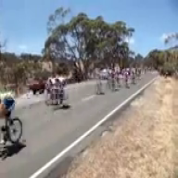

In [ ]:
def plot_random_image(dictionary, image_path_list):
  random_image_path = random.choice(image_path_list)

  path = os.path.relpath(random_image_path.parent, dataset_path)
  
  image_classes_name, image_classes_id = get_label_ids_names(dictionary, path)
  img = Image.open(random_image_path)

  print(f'Random image path: {random_image_path}')
  print(f'Image classes id: {image_classes_id}')
  print(f'Image classes name: {image_classes_name}')
  print(f'Image height: {img.height}') 
  print(f'Image width: {img.width}')

  return img

image_path_list = list(train_dir.glob('*/*/*.png'))
plot_random_image(train_dict, image_path_list)

Get the mean and standard deviation for the transform step

In [ ]:
# OK

def get_mean_std(dataloader):
  # VAR[X] = E[X**2] - E[X]**2
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for data, _ in dataloader:
    channels_sum += torch.mean(data, dim=[1,2])
    channels_squared_sum += torch.mean(data**2, dim=[1,2])
    num_batches += 1
  mean = channels_squared_sum / num_batches
  std = (channels_squared_sum / num_batches - mean**2)**0.5
  return mean, std

Transform

In [ ]:
# OK

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=174, std=174)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=174, std=174)
])

Dataset creation

In [ ]:
# OK

class VideoDataset(Dataset):
  def __init__(self, df, transform = None):
    self.df = df
    self.transform = transform
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    images_path = self.df.iloc[index, 0]

    images = [Image.open(f'{dataset_path}/{images_path}/{image}') 
              for image in os.listdir(f'{dataset_path}/{images_path}')]
    
    y_labels = torch.from_numpy(self.df.iloc[0, 1:].to_numpy().astype(float))

    if self.transform:
      new_images = torch.empty(shots, 3, 178, 178)
      for idx, image in enumerate(images): new_images[idx] = self.transform(image)
      return new_images, y_labels, images_path

    return images, y_labels, images_path

Split the training set into train and validation set

In [ ]:
# let's set the validations set to the 20% of the train dataset
def spit_train(train_data, perc_val_size):
  train_size = len(train_data)
  val_size = int((train_size * perc_val_size) // 100)
  train_size -= val_size

  return random_split(train_data, [int(train_size), int(val_size)]) #train_data, val_data 

In [ ]:
train_data, val_data = spit_train(VideoDataset(df=train_df, transform=train_transform), 20)
test_data = VideoDataset(df=test_df, transform=test_transform)

In [ ]:
# Check the lengths
print(len(train_data), len(val_data), len(test_data))

295 73 105


Random Image from the train dataloadera and test dataloader

Image tensor:
tensor([[[0.3804, 0.3843, 0.3843,  ..., 0.3412, 0.3412, 0.3412],
         [0.3804, 0.3843, 0.3843,  ..., 0.3412, 0.3412, 0.3412],
         [0.3843, 0.3882, 0.3882,  ..., 0.3451, 0.3451, 0.3412],
         ...,
         [0.6510, 0.6588, 0.6745,  ..., 0.7569, 0.7569, 0.7569],
         [0.6510, 0.6588, 0.6745,  ..., 0.7529, 0.7451, 0.7451],
         [0.6510, 0.6588, 0.6745,  ..., 0.7490, 0.7333, 0.7294]],

        [[0.3804, 0.3843, 0.3843,  ..., 0.3333, 0.3333, 0.3333],
         [0.3804, 0.3843, 0.3843,  ..., 0.3333, 0.3333, 0.3333],
         [0.3843, 0.3882, 0.3882,  ..., 0.3373, 0.3333, 0.3333],
         ...,
         [0.6471, 0.6549, 0.6706,  ..., 0.7294, 0.7294, 0.7333],
         [0.6471, 0.6549, 0.6706,  ..., 0.7255, 0.7176, 0.7176],
         [0.6471, 0.6549, 0.6706,  ..., 0.7216, 0.7059, 0.7020]],

        [[0.3686, 0.3725, 0.3725,  ..., 0.3647, 0.3725, 0.3725],
         [0.3686, 0.3725, 0.3725,  ..., 0.3647, 0.3725, 0.3725],
         [0.3686, 0.3765, 0.3765,  ..., 0.36

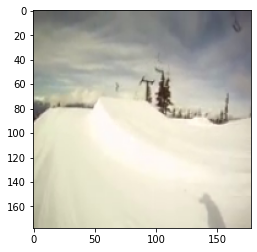

In [ ]:
rnd = random.choice(train_data)
frames, label, path = rnd
label_ids, label_names = get_label_ids_names(train_dict, path)

img = random.choice(frames)
print(f'Image tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label ids: {label_ids}')
print(f'Image label names: {label_names}')
print(f'Label datatype: {type(label)}')
plt.imshow(img.permute(1, 2, 0).numpy())

Turn loaded images into DataLoader's

In [ ]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 16 # ---------------------------- TODO: tune this paramenter ----------------------------
NUM_WORKERS = os.cpu_count()

def generate_dataloaders(train_data, test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):

  train_dl = DataLoader(dataset = train_data, 
                                batch_size = BATCH_SIZE,
                                num_workers = NUM_WORKERS,
                                shuffle = True)

  val_dl = DataLoader(dataset = val_data, 
                                batch_size = BATCH_SIZE,
                                num_workers = NUM_WORKERS,
                                shuffle = True)

  test_dl = DataLoader(dataset = test_data, 
                                batch_size = BATCH_SIZE, 
                                num_workers = NUM_WORKERS, 
                                shuffle = False) # don't need to shuffle testing data when we are considering time series dataset

  return train_dl, val_dl, test_dl

# Let's check out what we've created

train_dl, val_dl, test_dl = generate_dataloaders(train_data, test_data)

print(f'Length of train dataloader: {len(train_dl)} batches of {BATCH_SIZE}')
print(f'Length of val dataloader: {len(val_dl)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dl)} batches of {BATCH_SIZE}')

Length of train dataloader: 19 batches of 16
Length of val dataloader: 5 batches of 16
Length of test dataloader: 7 batches of 16


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch, _ = next(iter(train_dl))
print(train_features_batch.shape, train_labels_batch.shape)

val_features_batch, val_labels_batch, _ = next(iter(val_dl))
print(val_features_batch.shape, val_labels_batch.shape)

torch.Size([16, 30, 3, 178, 178]) torch.Size([16, 487])
torch.Size([16, 30, 3, 178, 178]) torch.Size([16, 487])


CNN definitions

In [ ]:
# OK

class AlexNet(nn.Module):
    def __init__(self, in_channels, stream_type=None, t_frames=[1,1,1]):
        # stream_type: none, "context", "fovea"
        # None is used for considering the cnn with spartial fusion informations
        super().__init__()

        # input size nomultiresulution : (b x 3 x 170 x 170)
        # input size multiresulution : (b x 3 x 178 x 178) take into account the video classifier -> which becomes 89 x 89 in both streams

        self.stream_type = stream_type
        self.fovea = transforms.Compose([transforms.CenterCrop((89, 89))])
        self.context = transforms.Compose([transforms.Resize((89, 89))])
        self.transform = transforms.Compose([transforms.Resize((170, 170))])
        self.t_frames = t_frames

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels*self.t_frames[0], 96, kernel_size=11, stride=3, padding=2),  
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 170 x 170) -> (b x 96 x 55 x 55)
            # MULTIRES -> in: (b x 96 x 89 x 89) -> (b x 96 x 28 x 28) 
            nn.ReLU(inplace=False),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 55 x 55) -> (b x 96 x 28 x 28)
            # MULTIRES -> in: (b x 96 x 28 x 28) -> (b x 96 x 14 x 14)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(96*self.t_frames[1], 256, kernel_size=5, stride=1, padding=2), 
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 28 x 28) -> (b x 256 x 28 x 28)
            # MULTIRES -> in: (b x 96 x 14 x 14) -> (b x 256 x 14 x 14)
            
            nn.ReLU(inplace=False),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # CORRECT
            # NO-MULTIRES -> in: (b x 256 x 28 x 28) -> (b x 256 x 14 x 14)
            # MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 256 x 7 x 7)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(256*self.t_frames[2], 384, kernel_size=3, stride=1, padding=1), 
            # CORRECT
            # NO-MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 384 x 14 x 14)
            # MULTIRES -> in: (b x 256 x 7 x 7) -> (b x 384 x 7 x 7)
            
            nn.ReLU(inplace=False),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # CORRECT
            # NO-MULTIRES -> in: (b x 384 x 14 x 14) -> (b x 384 x 14 x 14)
            # MULTIRES -> in: (b x 384 x 7 x 7) -> (b x 384 x 7 x 7)
            
            nn.ReLU(inplace=False),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            # CORRECT
            # NO-MULTIRES -> in: (b x 384 x 14 x 14) -> (b x 256 x 14 x 14)
            # MULTIRES -> in: (b x 384 x 7 x 7) -> (b x 256 x 7 x 7)
            
            nn.ReLU(inplace=False)
        )

        self.MaxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # CORRECT
        # NO-MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 256 x 7 x 7)

        self.init_bias()  # initialize bias

    def init_bias(self):
        for block in [self.conv1, self.conv2, self.conv3]:
            for layer in block:
              if isinstance(layer, nn.Conv2d):
                  nn.init.normal_(layer.weight, mean=0, std=0.01)
                  nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv2[0].bias, 1)
        nn.init.constant_(self.conv3[2].bias, 1)
        nn.init.constant_(self.conv3[4].bias, 1)


    def forward(self, x):
        if self.stream_type != None:
          x = self.fovea(x) if self.stream_type == 'fovea' else self.context(x)
          return self.conv3(self.conv2(self.conv1(x)))
        else: 
          x = self.transform(x)
          return self.MaxPool(self.conv3(self.conv2(self.conv1(x))))

In [ ]:
# OK

class MultiResolutionCNN(nn.Module):
    def __init__(self, AlexNet_fovea, AlexNet_context, num_classes):
        super(MultiResolutionCNN, self).__init__()
        self.AlexNet_fovea = AlexNet_fovea
        self.AlexNet_context = AlexNet_context

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(512 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        new_x1 = torch.empty(x.shape[0], 3, 178, 178)
        new_x2 = torch.empty(x.shape[0], 3, 178, 178)
        for i in range(x.shape[0]):
          new_x1[i] = x[i][7]
          new_x2[i] = x[i][7]

        new_x1 = self.AlexNet_fovea(new_x1)
        new_x2 = self.AlexNet_context(new_x2)
        x = torch.cat((new_x1, new_x2), dim=1)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [ ]:
# OK

class NoMultiresCNN(nn.Module):
    def __init__(self, CNN, num_classes):
        super(NoMultiresCNN, self).__init__()
        self.CNN = CNN

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

        
    def forward(self, x):
        new = torch.empty(x.shape[0], 3, 178, 178)
        for i in range(x.shape[0]): new[i] = x[i][7]
        x = self.CNN(new)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [ ]:
# ERROR

class LateFusionCNN(nn.Module):
    def __init__(self, AlexNet_1, AlexNet_2, num_classes):
        super(LateFusionCNN, self).__init__()
        self.AlexNet_1 = AlexNet_1
        self.AlexNet_2 = AlexNet_2

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(512 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        initial = torch.empty(x.shape[0], 3, 178, 178)
        final = torch.empty(x.shape[0], 3, 178, 178)
        for i in range(x.shape[0]):
          initial[i] = x[i][0]
          final[i] = x[i][14]

        initial = self.AlexNet_1(initial)
        final = self.AlexNet_2(final)
        x = torch.cat((initial, final), dim=1)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [ ]:
# OK

class EarlyFusionCNN(nn.Module):
    def __init__(self, AlexNet, num_classes):
        super(EarlyFusionCNN, self).__init__()
        self.AlexNet = AlexNet

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        new = torch.empty(x.shape[0],3*self.AlexNet.t_frames[0],178,178)
        for i in range(x.shape[0]): new[i] = x[i][5:10].reshape(3*self.AlexNet.t_frames[0],178,178)
       
        x = self.AlexNet(new)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [ ]:
# OK

class SlowFusionCNN(nn.Module):
    def __init__(self, AlexNet, num_classes):
        super(SlowFusionCNN, self).__init__()
        self.AlexNet = AlexNet

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        bag = torch.empty(4,x.shape[0],3*self.AlexNet.t_frames[0],178,178)

        for idx in range(bag.shape[0]):
          for i in range(x.shape[0]):
            bag[idx][i] = x[i][3+(idx*2):7+(idx*2)].reshape(3*self.AlexNet.t_frames[0],178,178)

        rconv2_2 = torch.cat((self.AlexNet.conv2(
            torch.cat((self.AlexNet.conv1(bag[0]), self.AlexNet.conv1(bag[1])), dim=1)
        ), self.AlexNet.conv2(
            torch.cat((self.AlexNet.conv1(bag[2]), self.AlexNet.conv1(bag[3])), dim=1)
        )), dim=1)

        x = self.AlexNet.MaxPool(self.AlexNet.conv3(rconv2_2))

        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [ ]:
class CNN_Architecture():

  def __init__(self, model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
    val_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module, accuracy_fn, scheduler: torch.optim.Optimizer, device: torch.device, save_check = False):

    self.model = model.to(device)
    self.optimizer = optimizer
    self.train_dataloader = train_dataloader
    self.loss_fn = loss_fn
    self.val_dataloader = val_dataloader
    self.accuracy_fn = accuracy_fn
    self.scheduler = scheduler
    self.device = device
    self.save_check = save_check

  def __save_checkpoint(self, train_loss, train_f1, epoch):
    data_path = Path('data/')
    filename = f'{self.model.typ}_checkpoint.pth.tar'
    print('=> Saving Checkpoint')
    checkpoint = {'state_dict': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'train_loss': train_loss, 'train_f1': train_f1, 'epoch': epoch}
    torch.save(checkpoint, filename)
    print(' DONE\n')

  def __load_checkpoint(self,checkpoint):
    self.model.load_state_dict(checkpoint['state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer'])
  

  def evaluate(self, val_dataloader: torch.utils.data.DataLoader, epoch = 1, epochs = 1):
    val_loss, val_f1 = 0, 0
    self.model.eval()

    pbar = tqdm(enumerate(val_dataloader), total = len(val_dataloader), leave=False) #, desc='EVALUATION'

    with torch.inference_mode():
      for batch_idx, (images, labels, _) in pbar: # there is a _ to ignore the paths
        images, labels = images.to(self.device), labels.to(self.device)

        outputs = self.model(images)

        #loss = self.loss_fn(outputs, labels).mean()
        loss = self.loss_fn(outputs, labels)
        f1 = self.accuracy_fn(outputs, labels)

        #val_loss +=  loss.data.mean()
        val_loss += loss
        val_f1 += f1
        
        pbar.set_description(f'{self.model.__class__.__name__} EVALUATION Epoch [{epoch + 1} / {epochs}]')
        pbar.set_postfix(loss = loss.item(), f1 = f1.item())
        
      val_loss /= len(val_dataloader) # already calculate the mean of all loss
      val_f1 /= len(val_dataloader) # already calculate the mean of all f1

    model_name = self.model.__class__.__name__
    if self.model.__class__.__name__ == 'NoMultiresCNN': model_name = f'{model_name} - Stream Type: {self.model.CNN.stream_type}'

    return { 'model_name': model_name, # only works when model was created with a class
             'model_loss': val_loss.item(),
             'model_f1': val_f1.item() }



  def fit(self, epochs: int):
    results = { 'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': [] }
    best_train_loss, best_train_f1 = float('inf'), float('-inf')

    for epoch in range(epochs):
      train_loss, train_f1 = 0, 0

      # Training phase
      self.model.train()

      pbar = tqdm(enumerate(self.train_dataloader), total = len(self.train_dataloader), leave=False) #, desc='TRAIN'
      
      for batch_idx, (images, labels, _) in pbar: # there is a _ to ignore the paths
        # zero_grad -> backword -> step

        self.optimizer.zero_grad()
        images, labels = images.to(self.device), labels.to(self.device)
        
        outputs = self.model(images)

        #loss = self.loss_fn(outputs, labels).mean()
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()

        #train_loss += loss.item()
        train_loss += loss.item()
        f1 = self.accuracy_fn(outputs, labels).item()

        train_f1 += f1

        model_name = self.model.__class__.__name__
        if self.model.__class__.__name__ == 'NoMultiresCNN': model_name = f'{model_name} - Stream Type: {self.model.CNN.stream_type}'

        pbar.set_description(f'{model_name} TRAIN Epoch [{epoch + 1} / {epochs}]')
        #pbar.set_postfix(loss = loss.data.mean().item(), f1 = f1)
        pbar.set_postfix(loss = loss.item(), f1 = f1)


      train_loss /= len(self.train_dataloader)
      train_f1 /= len(self.train_dataloader)


      self.scheduler.step(train_loss)

      if(self.save_check):
        if(train_loss < best_train_loss and train_f1 > best_train_f1):
          self.__save_checkpoint(train_loss, train_f1, epoch + 1)
          best_train_loss, best_train_f1 = train_loss, train_f1

      # Validation phase
      model_name, val_loss, val_f1 = (self.evaluate(self.val_dataloader, epoch, epochs)).values()


      results['train_loss'].append(train_loss)
      results['train_f1'].append(train_f1)
      results['val_loss'].append(val_loss)
      results['val_f1'].append(val_f1)

      print('Epoch [{}], train_loss: {:.4f}, train_f1: {:.4f}, val_loss: {:.4f}, val_f1: {:.4f} \n'.format(
            epoch + 1, train_loss, train_f1, val_loss, val_f1))

    return {'model_name': model_name, 'results': results}


  # still not used, here we display or example the top 5 predicted label
  def evaluate_and_plot_image(self, image_path: str, class_names, transform=None, mean=None, std=None):
    img = Image.open(image_path)

    if transform is not None: image_transform = transform
    else: image_transform = transforms.Compose([
            transforms.Resize((170, 170)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
         ])
    
    self.model.to(self.device)

    self.model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = self.model(transformed_image.to(self.device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Model: {self.model.__class__.__name__} | True Label: {str.split('/')[5]} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

In [ ]:
def accuracy(outputs, labels):
    #outputs = torch.logit(outputs)
    #shape = outputs.shape
    #outputs[outputs >= 0.5] = 1
    #return (outputs == labels).sum()/(shape[0]*shape[1])*100

    metric = MultilabelF1Score(num_labels=len(LABELS))
    return metric(outputs, labels)

In [ ]:
# Set number of epochs
NUM_EPOCHS = 5
n_class = len(LABELS)

#singleframe_model = NoMultiresCNN(AlexNet(in_channels=3), num_classes=n_class) # ---------- No problems
#singleframe_fovea_model = NoMultiresCNN(AlexNet(in_channels=3, stream_type='fovea'), num_classes=n_class) # ---------- No problems
#singleframe_context_model = NoMultiresCNN(AlexNet(in_channels=3, stream_type='context'), num_classes=n_class) # ---------- No problems
single_frame_multiresolution_model = MultiResolutionCNN(
    AlexNet(in_channels=3, stream_type='fovea'),
    AlexNet(in_channels=3, stream_type='context'),
num_classes=n_class) # ---------- No problems

#latefusion_model = LateFusionCNN(AlexNet(in_channels=3), AlexNet(in_channels=3), num_classes=n_class) # ---------- No problems
#earlyfusion_model = EarlyFusionCNN(AlexNet(in_channels=3, t_frames=[shot//3,1,1]), num_classes=n_class) # ---------- No problems
#slowfusion_model = SlowFusionCNN(AlexNet(in_channels=3, t_frames=[4,2,2]), num_classes=n_class) # ---------- No problems


# Setup loss function and optimizer
#loss_fn = nn.CrossEntropyLoss() # we are using CR loss so there is no need to add softmax layer as output
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.MultiLabelSoftMarginLoss()
#optimizer = torch.optim.SGD(params=multiresolution_model.parameters(), lr=1e-5, momentum=0.9, weight_decay=5e-5)
optimizer = torch.optim.Adam(params=single_frame_multiresolution_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [ ]:
CNN = CNN_Architecture(model = single_frame_multiresolution_model, 
             train_dataloader = train_dl,
             val_dataloader = val_dl,
             optimizer = optimizer,
             loss_fn = loss_fn,
             accuracy_fn = accuracy,
             scheduler = scheduler,
             device = device)

In [ ]:
def plot_loss_curves(results_info):
  res = results_info['results']
  epochs = range(len(res['train_loss']))

  plt.figure(figsize = (15, 7))
  plt.title(results_info['model_name'])

  plt.subplot(1, 2, 1)
  plt.plot(epochs, res['train_loss'], label = 'train_loss')
  plt.plot(epochs, res['val_loss'], label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, res['train_f1'], label = 'train_f1_accuracy')
  plt.plot(epochs, res['val_f1'], label = 'val_f1_accuracy')
  plt.title('F1 Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
def train_evaluate(model, epochs=NUM_EPOCHS):
  # Train model
  start_time = timer()
  history = model.fit(NUM_EPOCHS)
  end_time = timer()

  print(f'Total training time: {end_time-start_time:.3f} seconds')

  # Compare the results between train and validation set
  plot_loss_curves(history)

  # Evaluate model
  # Test the model in the Test Dataloader
  start_time = timer()
  result = model.evaluate(test_dl)
  end_time = timer()

  print(f'Total evaluation time: {end_time-start_time:.3f} seconds\n')
  print(f"TEST Results for {result['model_name']} -> loss: {result['model_loss']} f1-accuracy: {result['model_f1']}")

In [ ]:
train_evaluate(CNN)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3801, train_f1: 0.0017, val_loss: 0.0427, val_f1: 0.0021 



  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0096, train_f1: 0.0021, val_loss: 0.0001, val_f1: 0.0021 



  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0001, train_f1: 0.0021, val_loss: 0.0000, val_f1: 0.0021 



  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: ignored